# OpenVINO example with Squeezenet Model

This notebook illustrates how you can serve [OpenVINO](https://software.intel.com/en-us/openvino-toolkit) optimized models for Imagenet with Seldon Core.

<img src="dog.jpeg"/>

## Dependencies

 * Seldon-core (```pip install seldon-core```)
 * Numpy
 * Keras
 * Matplotlib
 * Tensorflow

## Download Squeezenet Model

We will download a pre-trained and optimized model for OpenVINO CPU into a local folder.

In [1]:
!mkdir -p models/squeezenet/1 && \
    wget -O models/squeezenet/1/squeezenet1.1.xml https://s3-eu-west-1.amazonaws.com/seldon-public/openvino-squeeznet-model/squeezenet1.1.xml && \
    wget -O models/squeezenet/1/squeezenet1.1.mapping https://s3-eu-west-1.amazonaws.com/seldon-public/openvino-squeeznet-model/squeezenet1.1.mapping && \
    wget -O models/squeezenet/1/squeezenet1.1.bin https://s3-eu-west-1.amazonaws.com/seldon-public/openvino-squeeznet-model/squeezenet1.1.bin 

--2019-01-07 12:40:12--  https://s3-eu-west-1.amazonaws.com/seldon-public/openvino-squeeznet-model/squeezenet1.1.xml
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.48.60
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.48.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37345 (36K) [text/xml]
Saving to: ‘models/squeezenet/1/squeezenet1.1.xml’

models/squeezenet/1 100%[===================>]  36.47K  --.-KB/s    in 0.02s   

2019-01-07 12:40:12 (1.47 MB/s) - ‘models/squeezenet/1/squeezenet1.1.xml’ saved [37345/37345]

--2019-01-07 12:40:12--  https://s3-eu-west-1.amazonaws.com/seldon-public/openvino-squeeznet-model/squeezenet1.1.mapping
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.48.60
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.48.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9318 (9.1K) [binary/octet-stream]

## Run Seldon Core on Minikube

**The example below assumes Minikube 0.30.0 installed**

In [2]:
!minikube start --memory 4096 --disk-size 20g

Starting local Kubernetes v1.12.4 cluster...
Starting VM...
Getting VM IP address...
Moving files into cluster...
Setting up certs...
Connecting to cluster...
Setting up kubeconfig...
Stopping extra container runtimes...
Starting cluster components...
Verifying kubelet health ...
Verifying apiserver health ...Kubectl is now configured to use the cluster.
Loading cached images from config file.


Everything looks great. Please enjoy minikube!


In [3]:
!kubectl create namespace seldon

namespace/seldon created


In [4]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "minikube" modified.


In [5]:
!kubectl create clusterrolebinding kube-system-cluster-admin --clusterrole=cluster-admin --serviceaccount=kube-system:default

clusterrolebinding.rbac.authorization.k8s.io/kube-system-cluster-admin created


In [6]:
!helm init

$HELM_HOME has been configured at /home/clive/.helm.

Tiller (the Helm server-side component) has been installed into your Kubernetes Cluster.

Please note: by default, Tiller is deployed with an insecure 'allow unauthenticated users' policy.
To prevent this, run `helm init` with the --tiller-tls-verify flag.
For more information on securing your installation see: https://docs.helm.sh/using_helm/#securing-your-helm-installation
Happy Helming!


In [7]:
!kubectl rollout status deploy/tiller-deploy -n kube-system

Waiting for deployment "tiller-deploy" rollout to finish: 0 of 1 updated replicas are available...
deployment "tiller-deploy" successfully rolled out


In [8]:
!helm install ../../../helm-charts/seldon-core-crd --name seldon-core-crd  --set usage_metrics.enabled=true
!helm install ../../../helm-charts/seldon-core --name seldon-core --set ambassador.enabled=true

NAME:   seldon-core-crd
LAST DEPLOYED: Mon Jan  7 12:56:17 2019
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/ConfigMap
NAME                     DATA  AGE
seldon-spartakus-config  3     5s

==> v1beta1/CustomResourceDefinition
NAME                                         AGE
seldondeployments.machinelearning.seldon.io  1s

==> v1beta1/Deployment
NAME                        DESIRED  CURRENT  UP-TO-DATE  AVAILABLE  AGE
seldon-spartakus-volunteer  1        0        0           0          1s

==> v1/ServiceAccount
NAME                        SECRETS  AGE
seldon-spartakus-volunteer  1        1s

==> v1beta1/ClusterRole
NAME                        AGE
seldon-spartakus-volunteer  1s

==> v1beta1/ClusterRoleBinding
NAME                        AGE
seldon-spartakus-volunteer  1s


NOTES:
NOTES: TODO


NAME:   seldon-core
LAST DEPLOYED: Mon Jan  7 12:56:22 2019
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1beta1/Role
NAME          AGE
seldon-local  0s
ambassador    0s

==> v1/RoleB

## (Optional) Install Jaeger

We will use the Jaeger All-in-1 resource found at the [Jaeger Kubernetes repo](https://github.com/jaegertracing/jaeger-kubernetes).

In [9]:
!kubectl create -f https://raw.githubusercontent.com/jaegertracing/jaeger-kubernetes/master/all-in-one/jaeger-all-in-one-template.yml -n seldon

deployment.extensions/jaeger-deployment created
service/jaeger-query created
service/jaeger-collector created
service/jaeger-agent created
service/zipkin created


### Start Jaeger UI

```
minikube service jaeger-query -n seldon
```

## Mount local folder onto minikube for HostPath
Run in the current folder:
```
minikube mount ./models:/opt/ml
```

This will allow the model folder containing the Squeezenet model to be accessed. For production deployments you would use a NFS volume.

## Build Combiner and Transformer Images

In [49]:
!eval $(minikube docker-env) && cd resources/combiner && s2i build -E environment_grpc . seldonio/seldon-core-s2i-python36:0.5-SNAPSHOT seldonio/imagenet_combiner:0.1

---> Installing application source...
Build completed successfully


In [50]:
!eval $(minikube docker-env) && cd resources/transformer && s2i build -E environment_grpc . seldonio/seldon-core-s2i-python36:0.5-SNAPSHOT seldonio/imagenet_transformer:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


## Deploy Seldon Intel OpenVINO Graph

In [12]:
import sys
sys.path.append("../../../notebooks")
from visualizer import *

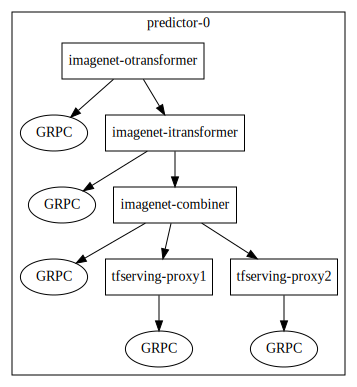

In [13]:
get_graph("seldon_openvino_ensemble.json")

In [13]:
!pygmentize seldon_openvino_ensemble.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "openvino-model",
	"namespace": "seldon"	
    },
    "spec": {
        "name": "openvino",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "name": "imagenet-itransformer",				
                                "image": "seldonio/imagenet_transformer:0.1",
				"env": [
				    {
					"name": "TRACING",
					"value": "1"
				    },
				    {
					"name": "JAEGER_AGENT_HOST",
					"value": "jaeger-agent"
				    }
				]
                            },
                            {
                                "name": "imagenet-otransformer",				
                                "image": "seldonio/imagenet_transformer:0.1",
				"env": [
				    {
					"na

In [51]:
!kubectl apply -f pvc.json
!kubectl apply -f seldon_openvino_ensemble.json

persistentvolume/hostpath-pvc unchanged
persistentvolumeclaim/model-store-pvc unchanged
seldondeployment.machinelearning.seldon.io/openvino-model created


# Serve Requests

**Ensure you port forward ambassador:**

```
kubectl port-forward $(kubectl get pods -n seldon -l service=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon 8003:8080
```

In [30]:
import tensorflow as tf
from seldon_core.proto import prediction_pb2
from seldon_core.proto import prediction_pb2_grpc
import grpc

def grpc_request_ambassador_tensor(deploymentName,namespace,endpoint="localhost:8004",data=None):
    datadef = prediction_pb2.DefaultData(
                names = 'x',
                tftensor = tf.make_tensor_proto(data)
            )
    request = prediction_pb2.SeldonMessage(data = datadef)
    channel = grpc.insecure_channel(endpoint)
    stub = prediction_pb2_grpc.SeldonStub(channel)
    if namespace is None:
        metadata = [('seldon',deploymentName)]
    else:
        metadata = [('seldon',deploymentName),('namespace',namespace)]
    response = stub.Predict(request=request,metadata=metadata)
    return response

def grpc_request_ambassador_bindata(deploymentName,namespace,endpoint="localhost:8004",data=None):
    request = prediction_pb2.SeldonMessage(binData = data)
    channel = grpc.insecure_channel(endpoint)
    stub = prediction_pb2_grpc.SeldonStub(channel)
    if namespace is None:
        metadata = [('seldon',deploymentName)]
    else:
        metadata = [('seldon',deploymentName),('namespace',namespace)]
    response = stub.Predict(request=request,metadata=metadata)
    return response


In [56]:
%matplotlib inline
import numpy as np
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image
import sys
import json
import matplotlib.pyplot as plt
import datetime
API_AMBASSADOR="localhost:8003"

def getImage(path):
    img = image.load_img(path, target_size=(227, 227))
    x = image.img_to_array(img)
    plt.imshow(x/255.)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def getImageRaw(path):
    img = image.load_img(path, target_size=(227, 227))
    x = image.img_to_array(img)
    plt.imshow(x/255.)
    return x

def getImageBytes(path):
    with open(path, mode='rb') as file: 
        fileContent = file.read()
    return fileContent

#X = getImage("car.png")
#X = X.transpose((0,3,1,2))

#X = getImageRaw("car.png")
#X = getImageRaw("dog.jpeg")
#print(X.shape)
X = getImageBytes("dog.jpeg")
start_time = datetime.datetime.now()
response = grpc_request_ambassador_bindata("openvino-model","seldon",API_AMBASSADOR,data=X)
end_time = datetime.datetime.now()
duration = (end_time - start_time).total_seconds() * 1000
print(duration)

print(response.strData)


135.026
Eskimo dog, husky


Send multiple requests to get average response time.

In [58]:
durations = []
for i in range(100):
    X = getImageBytes("dog.jpeg")
    start_time = datetime.datetime.now()
    response = grpc_request_ambassador_bindata("openvino-model","seldon",API_AMBASSADOR,data=X)
    end_time = datetime.datetime.now()
    duration = (end_time - start_time).total_seconds() * 1000
    durations.append(duration)
print(sum(durations)/float(len(durations)))

130.20825
